## Import stuff and load calculations

In [1]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import os, sys
sys.path.append(f"{os.path.dirname(os.getcwd())}/scripts")

In [2]:
# from creative_and_factual_metrics import *

In [3]:
from sentence_transformers import SentenceTransformer
from diversity_metrics.metrics.model_free_metrics import *
from diversity_metrics.embeddings.models import *
from diversity_metrics.metrics.generalized_diversity import *

In [4]:
llama2_results_5_words = np.load(f"{os.path.dirname(os.getcwd())}/results/creative_factual/llama2_results_5_words.npy", allow_pickle=True).item()
llama2_chat_results_5_words = np.load(f"{os.path.dirname(os.getcwd())}/results/creative_factual/llama2-chat_results_5_words.npy", allow_pickle=True).item()
llama2_sft_results_5_words  = np.load(f"{os.path.dirname(os.getcwd())}/results/creative_factual/llama2-sft_results_5_words.npy", allow_pickle=True).item()
llama2_dpo_results_5_words  = np.load(f"{os.path.dirname(os.getcwd())}/results/creative_factual/llama2-dpo_results_5_words.npy", allow_pickle=True).item()
llama2_ppo_results_5_words  = np.load(f"{os.path.dirname(os.getcwd())}/results/creative_factual/llama2-ppo_results_5_words.npy", allow_pickle=True).item()

llama2_results_20_words = np.load(f"{os.path.dirname(os.getcwd())}/results/creative_factual/llama2_results_20_words.npy", allow_pickle=True).item()
llama2_chat_results_20_words = np.load(f"{os.path.dirname(os.getcwd())}/results/creative_factual/llama2-chat_results_20_words.npy", allow_pickle=True).item()
llama2_sft_results_20_words  = np.load(f"{os.path.dirname(os.getcwd())}/results/creative_factual/llama2-sft_results_20_words.npy", allow_pickle=True).item()
llama2_dpo_results_20_words  = np.load(f"{os.path.dirname(os.getcwd())}/results/creative_factual/llama2-dpo_results_20_words.npy", allow_pickle=True).item()
llama2_ppo_results_20_words  = np.load(f"{os.path.dirname(os.getcwd())}/results/creative_factual/llama2-ppo_results_20_words.npy", allow_pickle=True).item()

## Functions

In [5]:
temperatures = [k / 10. for k in range(1, 16)]
temperatures

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]

In [6]:
from functools import partial

def limit_num_words(sentence, max_num_words):
    return " ".join(sentence.split()[:max_num_words])


def average_pairwise_jaccard(sentences, n=2):
    return np.mean([pairwise_ngram(n, x, y) for x, y in combinations(sentences, 2)])

def self_bleu_smooth(sentences):
    '''
    Calculates the Self-BLEU score for a collection of generated examples (https://arxiv.org/abs/1802.01886)
    :param sentences: List of generated examples
    :return:
    '''

    scores = []
    for i, hypothesis in enumerate(sentences):
        hypothesis_split = hypothesis.strip().split()

        references = [sentences[j].strip().split() for j in range(len(sentences)) if i != j]

        scores.append(sentence_bleu(references, hypothesis_split, smoothing_function=SmoothingFunction().method1))

    return sum(scores) / len(scores)

diversity_metrics = {"selfBleuSmoothed": self_bleu_smooth,
                    "average_pairwise_ncd": lambda sentences: np.mean(get_pairwise_ncd(sentences)),
                     "average_pairwise_jaccard_2": partial(average_pairwise_jaccard, n=2),
                    "average_pairwise_jaccard_3": partial(average_pairwise_jaccard, n=3),
                    "average_pairwise_jaccard_4": partial(average_pairwise_jaccard, n=4),
                    "avg_compression_ratio_full": avg_compression_ratio_full,
                    "avg_compression_ratio_target": avg_compression_ratio_target,
                    "cosine_similarity": None # will be filled in later
                    }

## Plot output diversity metrics

In [7]:
metric_label = ["Self Bleu Smoothed", "Self Bleu Smoothed", "Average Pairwise NCD", "Average Pairwise NCD", 
               "Average Pairwise Jaccard 2", "Average Pairwise Jaccard 2", "Average Pairwise Jaccard 3", 
               "Average Pairwise Jaccard 3", "Average Pairwise Jaccard 4", "Average Pairwise Jaccard 4", 
               "Average Compression Ratio Full", "Average Compression Ratio Full","Average Compression Ratio Target", 
               "Average Compression Ratio Target", "Cosine Similarity", "Cosine Similarity"]

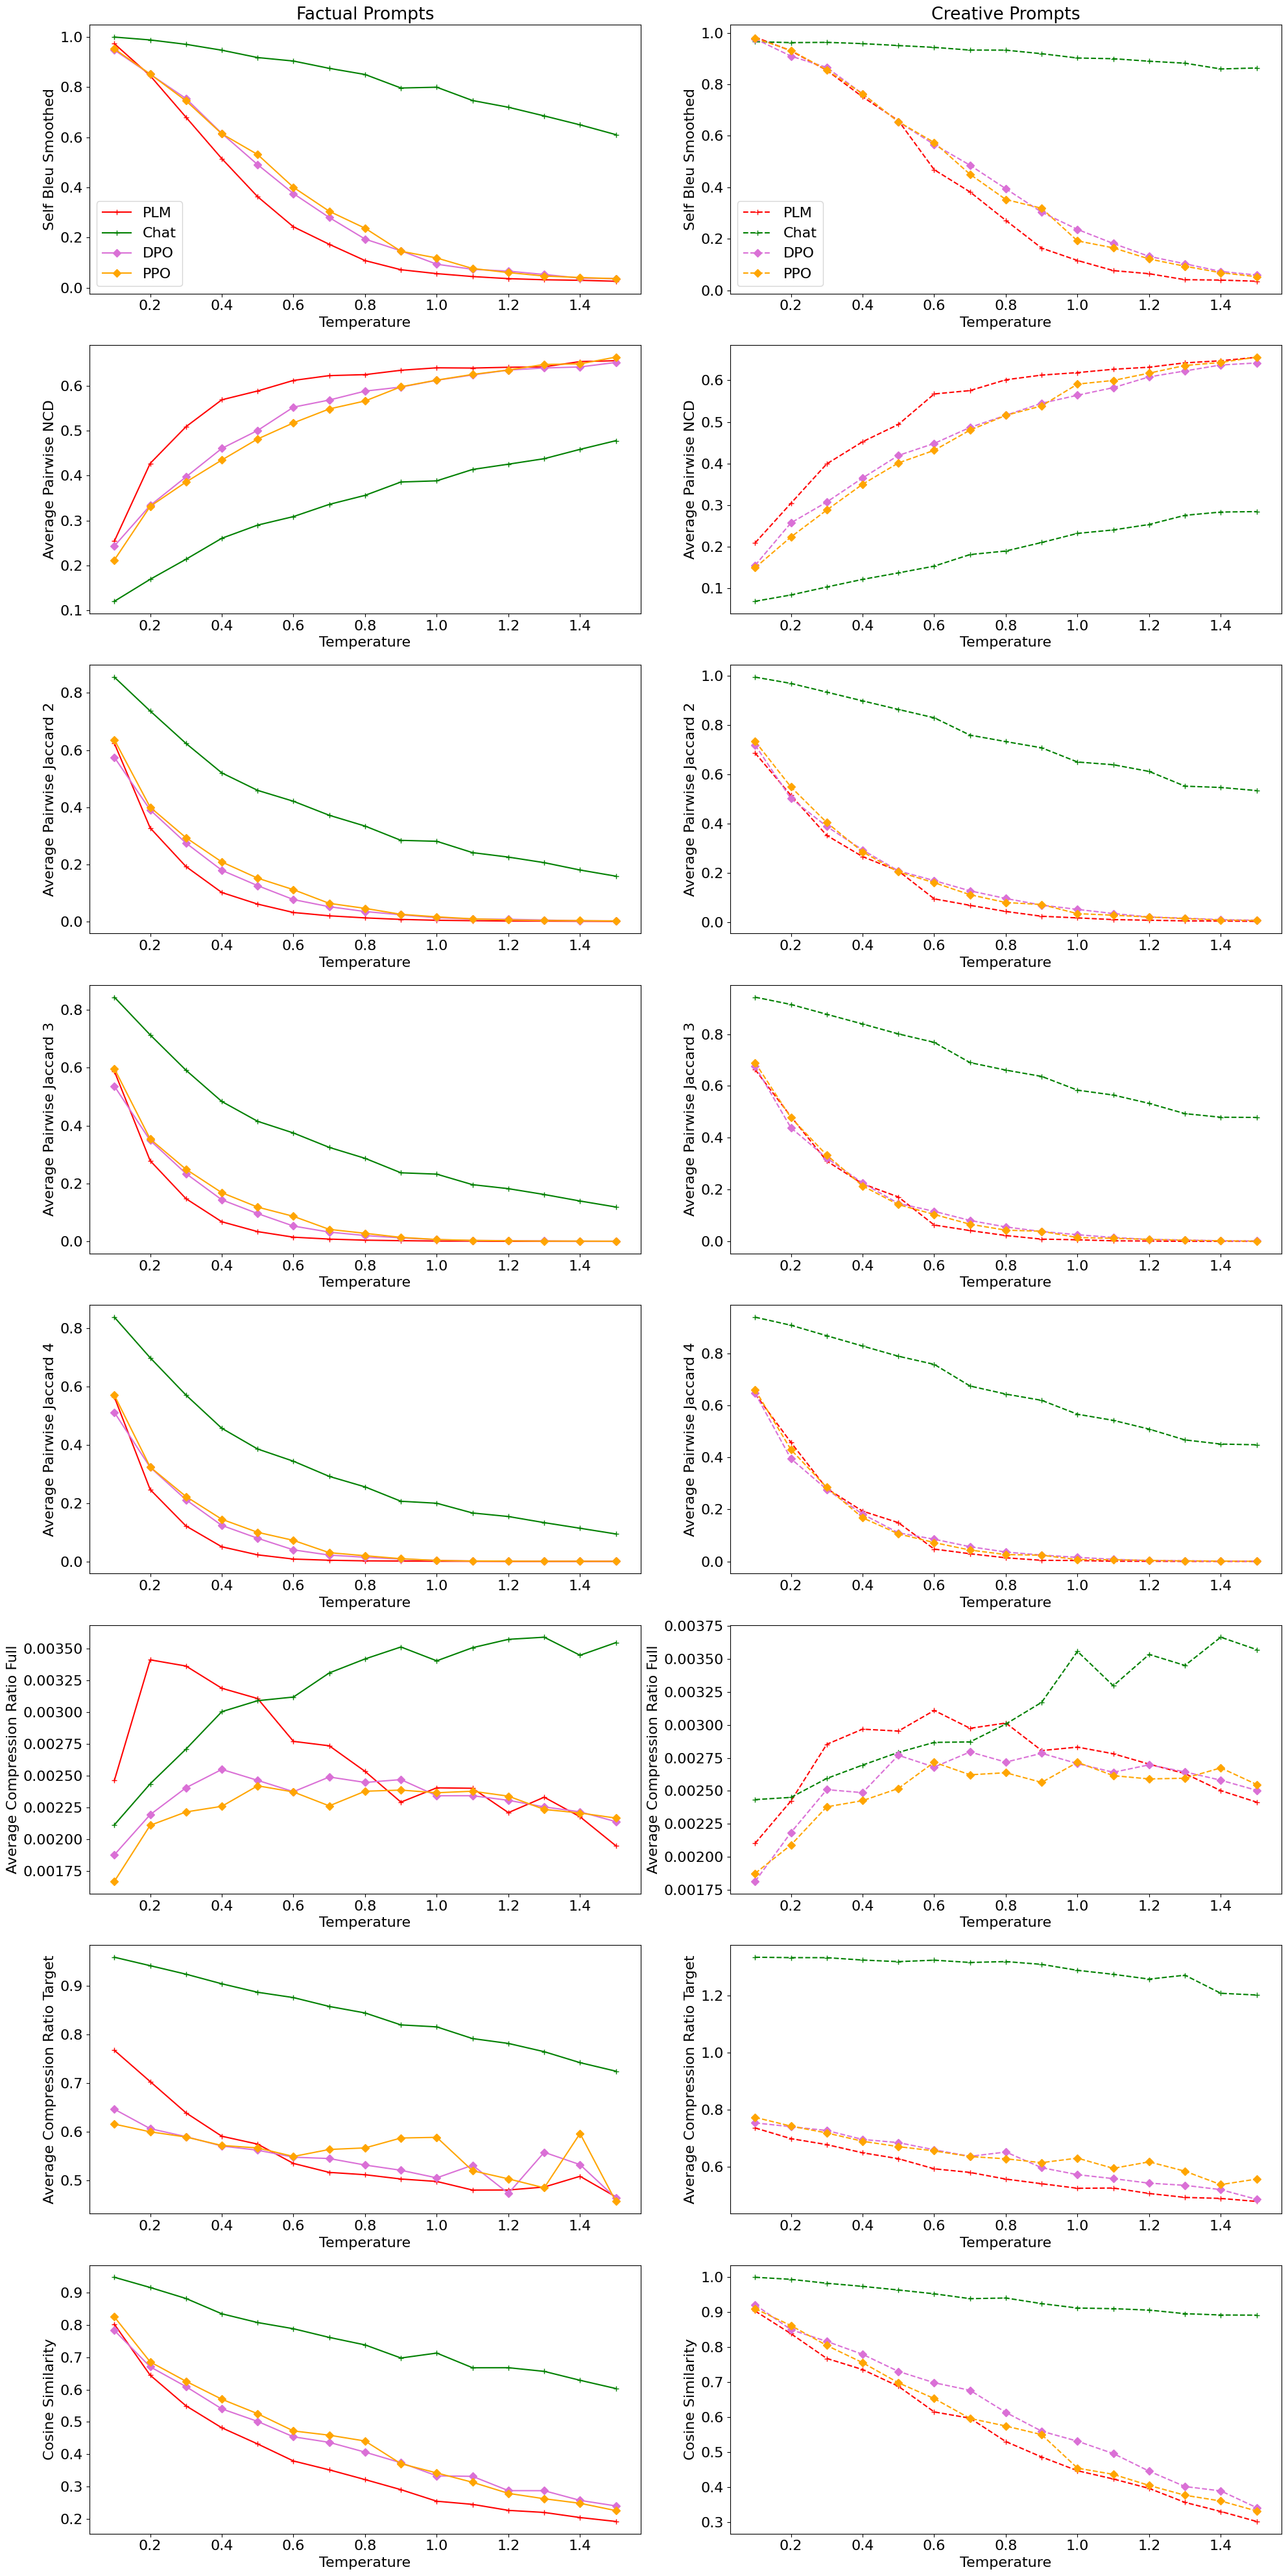

In [20]:
creative_factual_full_f = f"{os.path.dirname(os.getcwd())}/results/creative_factual_llama_finetune_full.png"

num_metrics = len(diversity_metrics.keys())
fig, axes = plt.subplots(num_metrics, 2, figsize=(20, 5*num_metrics))
# make font bigger
plt.rcParams.update({'font.size': 16})

text_effect = [path_effects.withStroke(linewidth=3, foreground='white')]

i=0
for index, metric in enumerate(diversity_metrics.keys()):
    # for col_idx, result_sft in enumerate([llama2_sft_results_20_words]):
        # ax = axes[index, col_idx]

        result_sft = [llama2_sft_results_20_words][0]
        scores_factual_sft = result_sft["factual"][metric]
        scores_creative_sft = result_sft["creative"][metric]

        result_plm = [llama2_results_20_words][0]
        scores_factual_plm = result_plm["factual"][metric]
        scores_creative_plm = result_plm["creative"][metric]

        result_chat = [llama2_chat_results_20_words][0]
        scores_factual_chat = result_chat["factual"][metric]
        scores_creative_chat = result_chat["creative"][metric]

        result_dpo = [llama2_dpo_results_20_words][0]
        scores_factual_dpo = result_dpo["factual"][metric]
        scores_creative_dpo = result_dpo["creative"][metric]

        result_ppo = [llama2_ppo_results_20_words][0]
        scores_factual_ppo = result_ppo["factual"][metric]
        scores_creative_ppo = result_ppo["creative"][metric]
        
        ax1 = axes[index, 1]
        # Plotting for creative scores
        ax1.plot(temperatures, np.nanmean(scores_creative_plm[:, :, 0],axis=1), label='llama2 creative', marker='+', linestyle='--', color="red")
        ax1.plot(temperatures, np.nanmean(scores_creative_chat[:, :, 0],axis=1), label='llama2-chat creative', marker='+', linestyle='--', color="green")
        # ax1.plot(temperatures, np.nanmean(scores_creative_sft[:, :, 0],axis=1), label='llama2-sft creative', marker='o', linestyle='--', color="blue")
        ax1.plot(temperatures, np.nanmean(scores_creative_dpo[:, :, 0],axis=1), label='llama2-dpo creative', marker='D', linestyle='--', color="orchid")
        ax1.plot(temperatures, np.nanmean(scores_creative_ppo[:, :, 0],axis=1), label='llama2-ppo creative', marker='D', linestyle='--', color="orange")
        if i==0: ax1.legend(['PLM', 'Chat', 'DPO', 'PPO'])
        if i==0: ax1.title.set_text('Creative Prompts')
        ax1.set_xlabel('Temperature')
        ax1.set_ylabel(metric_label[i])
        ymin, ymax = ax1.get_ylim() # want same ylims to compare, go off of creative since higher in certain metrics

        ax0 = axes[index, 0]
        # Plotting for factual scores
        ax0.plot(temperatures, np.nanmean(scores_factual_plm[:, :, 0],axis=1), label='llama2 factual', marker='+', color="red")
        ax0.plot(temperatures, np.nanmean(scores_factual_chat[:, :, 0],axis=1), label='llama2-chat factual', marker='+', color="green")
        # ax0.plot(temperatures, np.nanmean(scores_factual_sft[:, :, 0],axis=1), label='llama2-sft factual', marker='o', color="blue")
        ax0.plot(temperatures, np.nanmean(scores_factual_dpo[:, :, 0],axis=1), label='llama2-dpo factual', marker='D', color="orchid")
        ax0.plot(temperatures, np.nanmean(scores_factual_ppo[:, :, 0],axis=1), label='llama2-ppo factual', marker='D', color="orange")
        if i==0: ax0.legend(['PLM', 'Chat', 'DPO', 'PPO'])
        if i==0: ax0.title.set_text('Factual Prompts')
        ax0.set_xlabel('Temperature')
        ax0.set_ylabel(metric_label[i])
        ax1.set_ylim([ymin, ymax])

        i+=2
    
plt.tight_layout()
plt.show()

fig.savefig(creative_factual_full_f, bbox_inches="tight") 
plt.close()

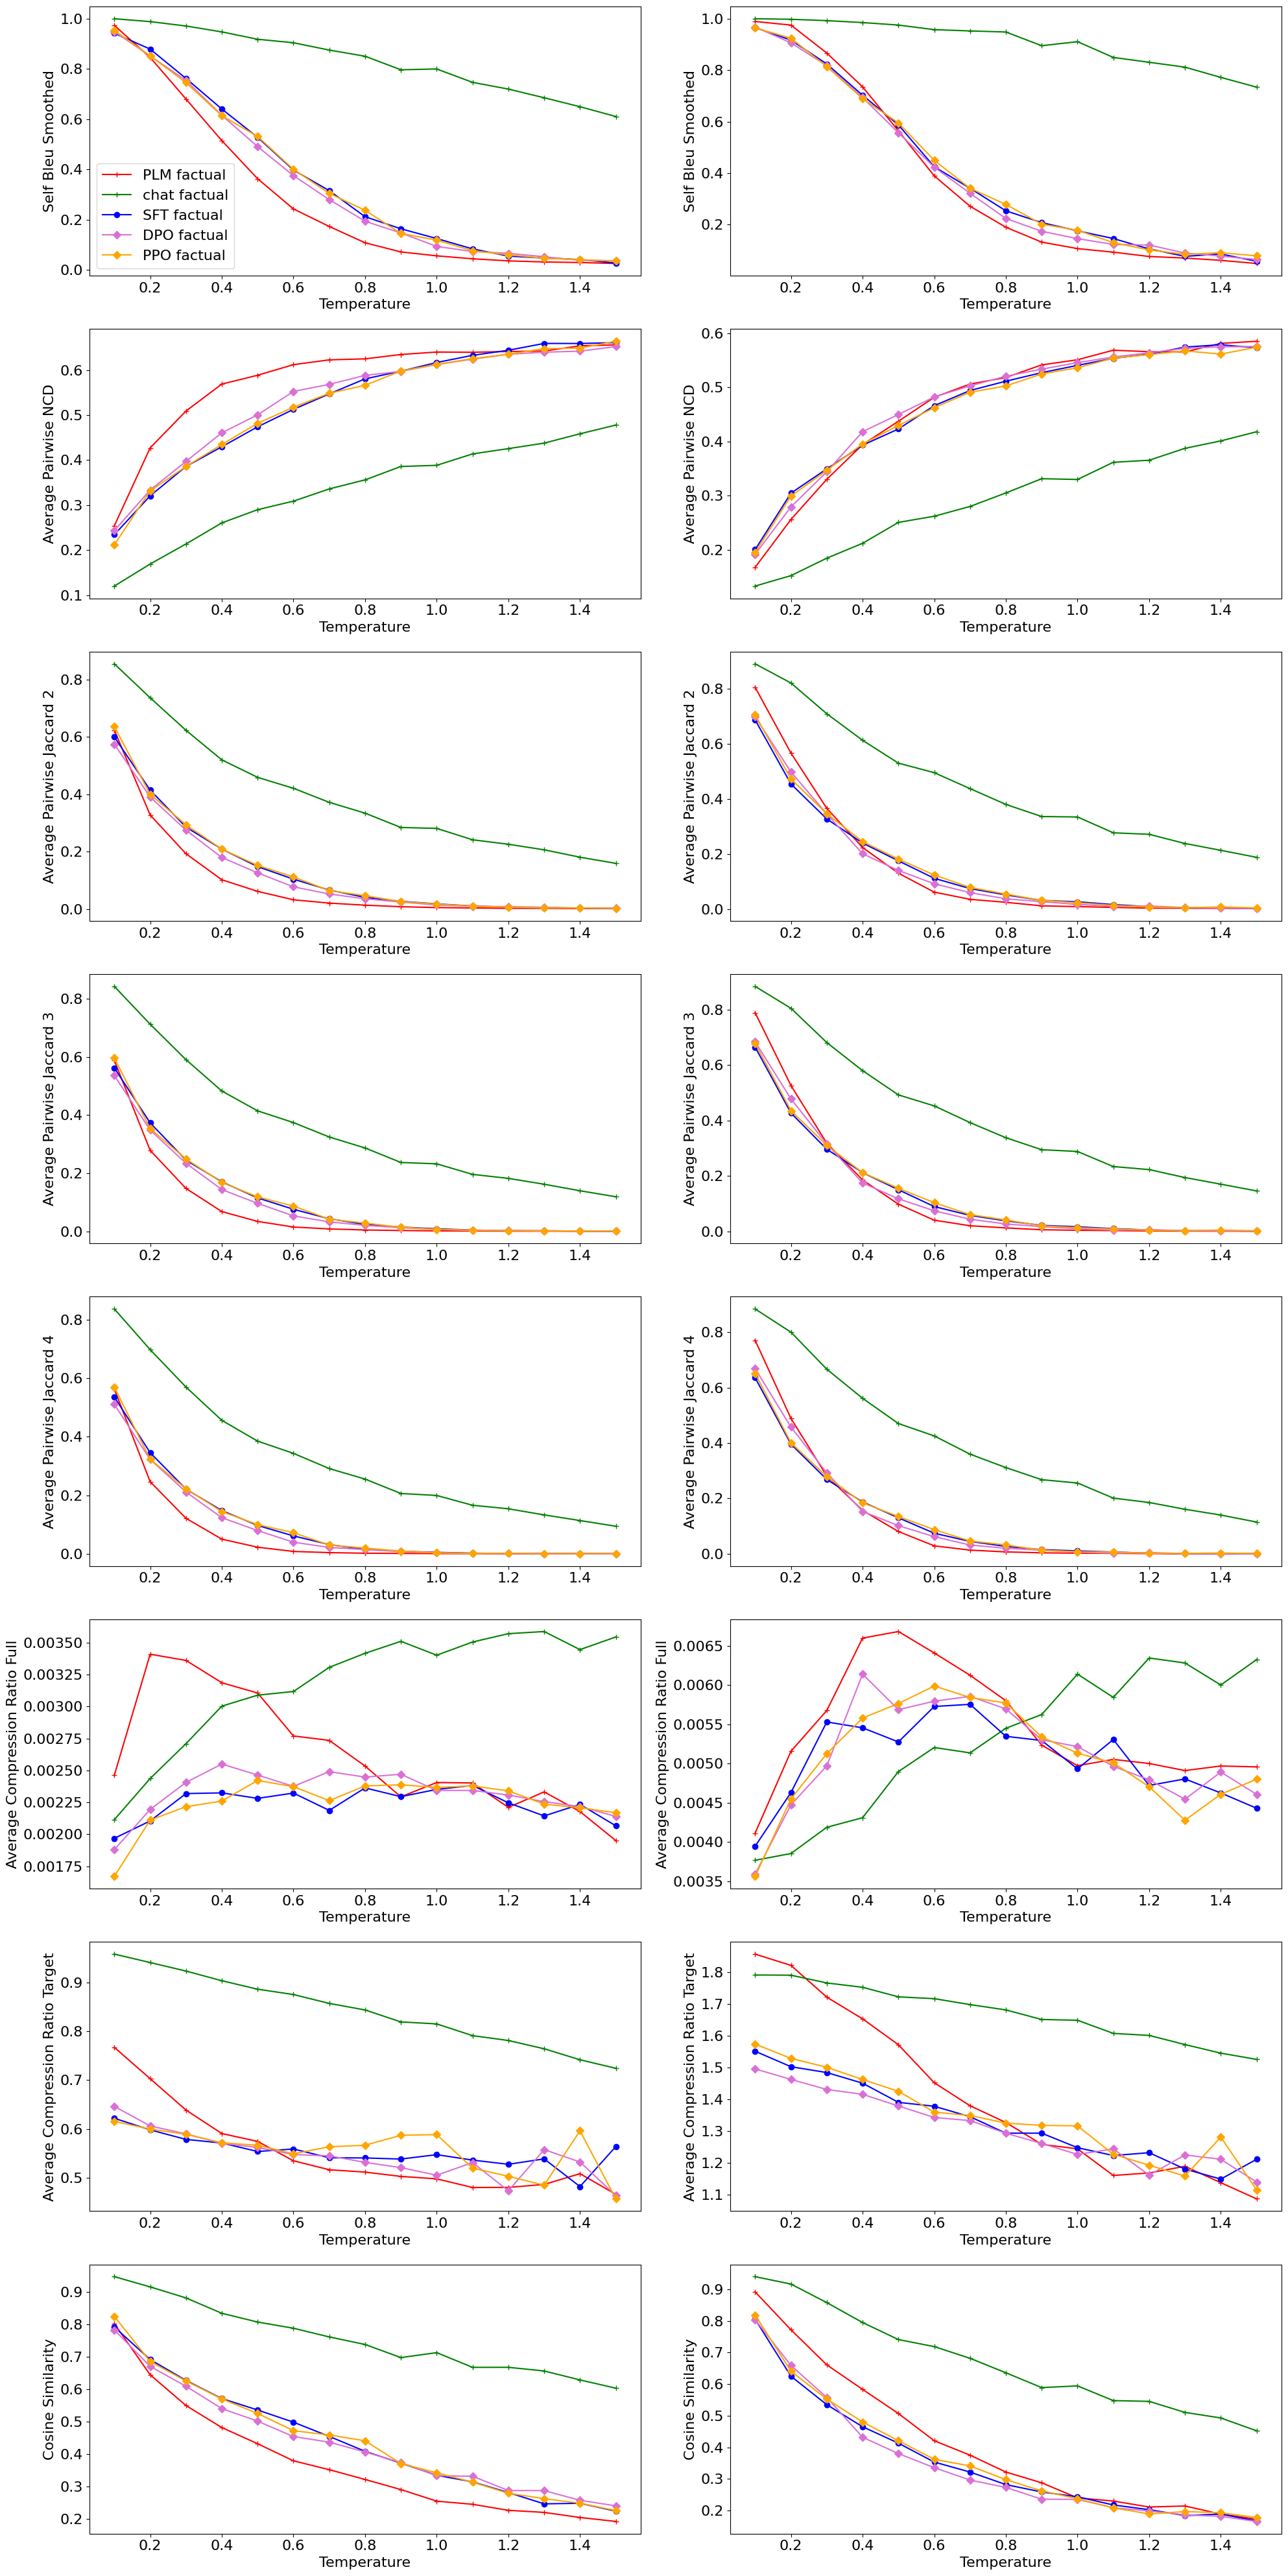

In [14]:
# creative_factual_full_f = f"{os.path.dirname(os.getcwd())}/results/creative_factual_llama_finetune_full.png"

num_metrics = len(diversity_metrics.keys())
fig, axes = plt.subplots(num_metrics, 2, figsize=(20, 5*num_metrics))
# make font bigger
plt.rcParams.update({'font.size': 16})

text_effect = [path_effects.withStroke(linewidth=3, foreground='white')]

i=0
for index, metric in enumerate(diversity_metrics.keys()):

    for col_idx, result_sft in enumerate([llama2_sft_results_20_words, llama2_sft_results_5_words]):
        ax = axes[index, col_idx]

        scores_factual_sft = result_sft["factual"][metric]
        scores_creative_sft = result_sft["creative"][metric]

        result_plm = [llama2_results_20_words, llama2_results_5_words][col_idx]
        scores_factual_plm = result_plm["factual"][metric]
        scores_creative_plm = result_plm["creative"][metric]

        result_chat = [llama2_chat_results_20_words, llama2_chat_results_5_words][col_idx]
        scores_factual_chat = result_chat["factual"][metric]
        scores_creative_chat = result_chat["creative"][metric]

        result_dpo = [llama2_dpo_results_20_words, llama2_dpo_results_5_words][col_idx]
        scores_factual_dpo = result_dpo["factual"][metric]
        scores_creative_dpo = result_dpo["creative"][metric]

        result_ppo = [llama2_ppo_results_20_words, llama2_ppo_results_5_words][col_idx]
        scores_factual_ppo = result_ppo["factual"][metric]
        scores_creative_ppo = result_ppo["creative"][metric]

        # Plotting for factual scores
        ax.plot(temperatures, np.nanmean(scores_factual_plm[:, :, 0],axis=1), label='llama2 factual', marker='+', color="red")
        ax.plot(temperatures, np.nanmean(scores_factual_chat[:, :, 0],axis=1), label='llama2-chat factual', marker='+', color="green")
        ax.plot(temperatures, np.nanmean(scores_factual_sft[:, :, 0],axis=1), label='llama2-sft factual', marker='o', color="blue")
        ax.plot(temperatures, np.nanmean(scores_factual_dpo[:, :, 0],axis=1), label='llama2-dpo factual', marker='D', color="orchid")
        ax.plot(temperatures, np.nanmean(scores_factual_ppo[:, :, 0],axis=1), label='llama2-ppo factual', marker='D', color="orange")

        # Plotting for creative scores
        # ax.plot(temperatures, np.nanmean(scores_creative_plm[:, :, 0],axis=1), label='llama2 creative', marker='+', linestyle='--', color="salmon")
        # ax.plot(temperatures, np.nanmean(scores_creative_chat[:, :, 0],axis=1), label='llama2-chat creative', marker='+', linestyle='--', color="salmon")
        # ax.plot(temperatures, np.nanmean(scores_creative_sft[:, :, 0],axis=1), label='llama2-sft creative', marker='o', linestyle='--', color="lightblue")
        # ax.plot(temperatures, np.nanmean(scores_creative_dpo[:, :, 0],axis=1), label='llama2-dpo creative', marker='D', linestyle='--', color="pink")
        # ax.plot(temperatures, np.nanmean(scores_creative_ppo[:, :, 0],axis=1), label='llama2-ppo creative', marker='D', linestyle='--', color="yellow")

        ax.set_xlabel('Temperature')
        ax.set_ylabel(metric_label[i])
        # text_effect = [path_effects.withStroke(linewidth=3, foreground='white')]
        if i==0:
            ax.legend(['PLM factual', 'chat factual', 'SFT factual', 'DPO factual', 'PPO factual', 'PML creative', 'chat creative', 'SFT creative', 'DPO creative', 'PPO creative'])
        i+=1


plt.tight_layout()
plt.show()

# fig.savefig(creative_factual_full_f, bbox_inches="tight") 
# plt.close()


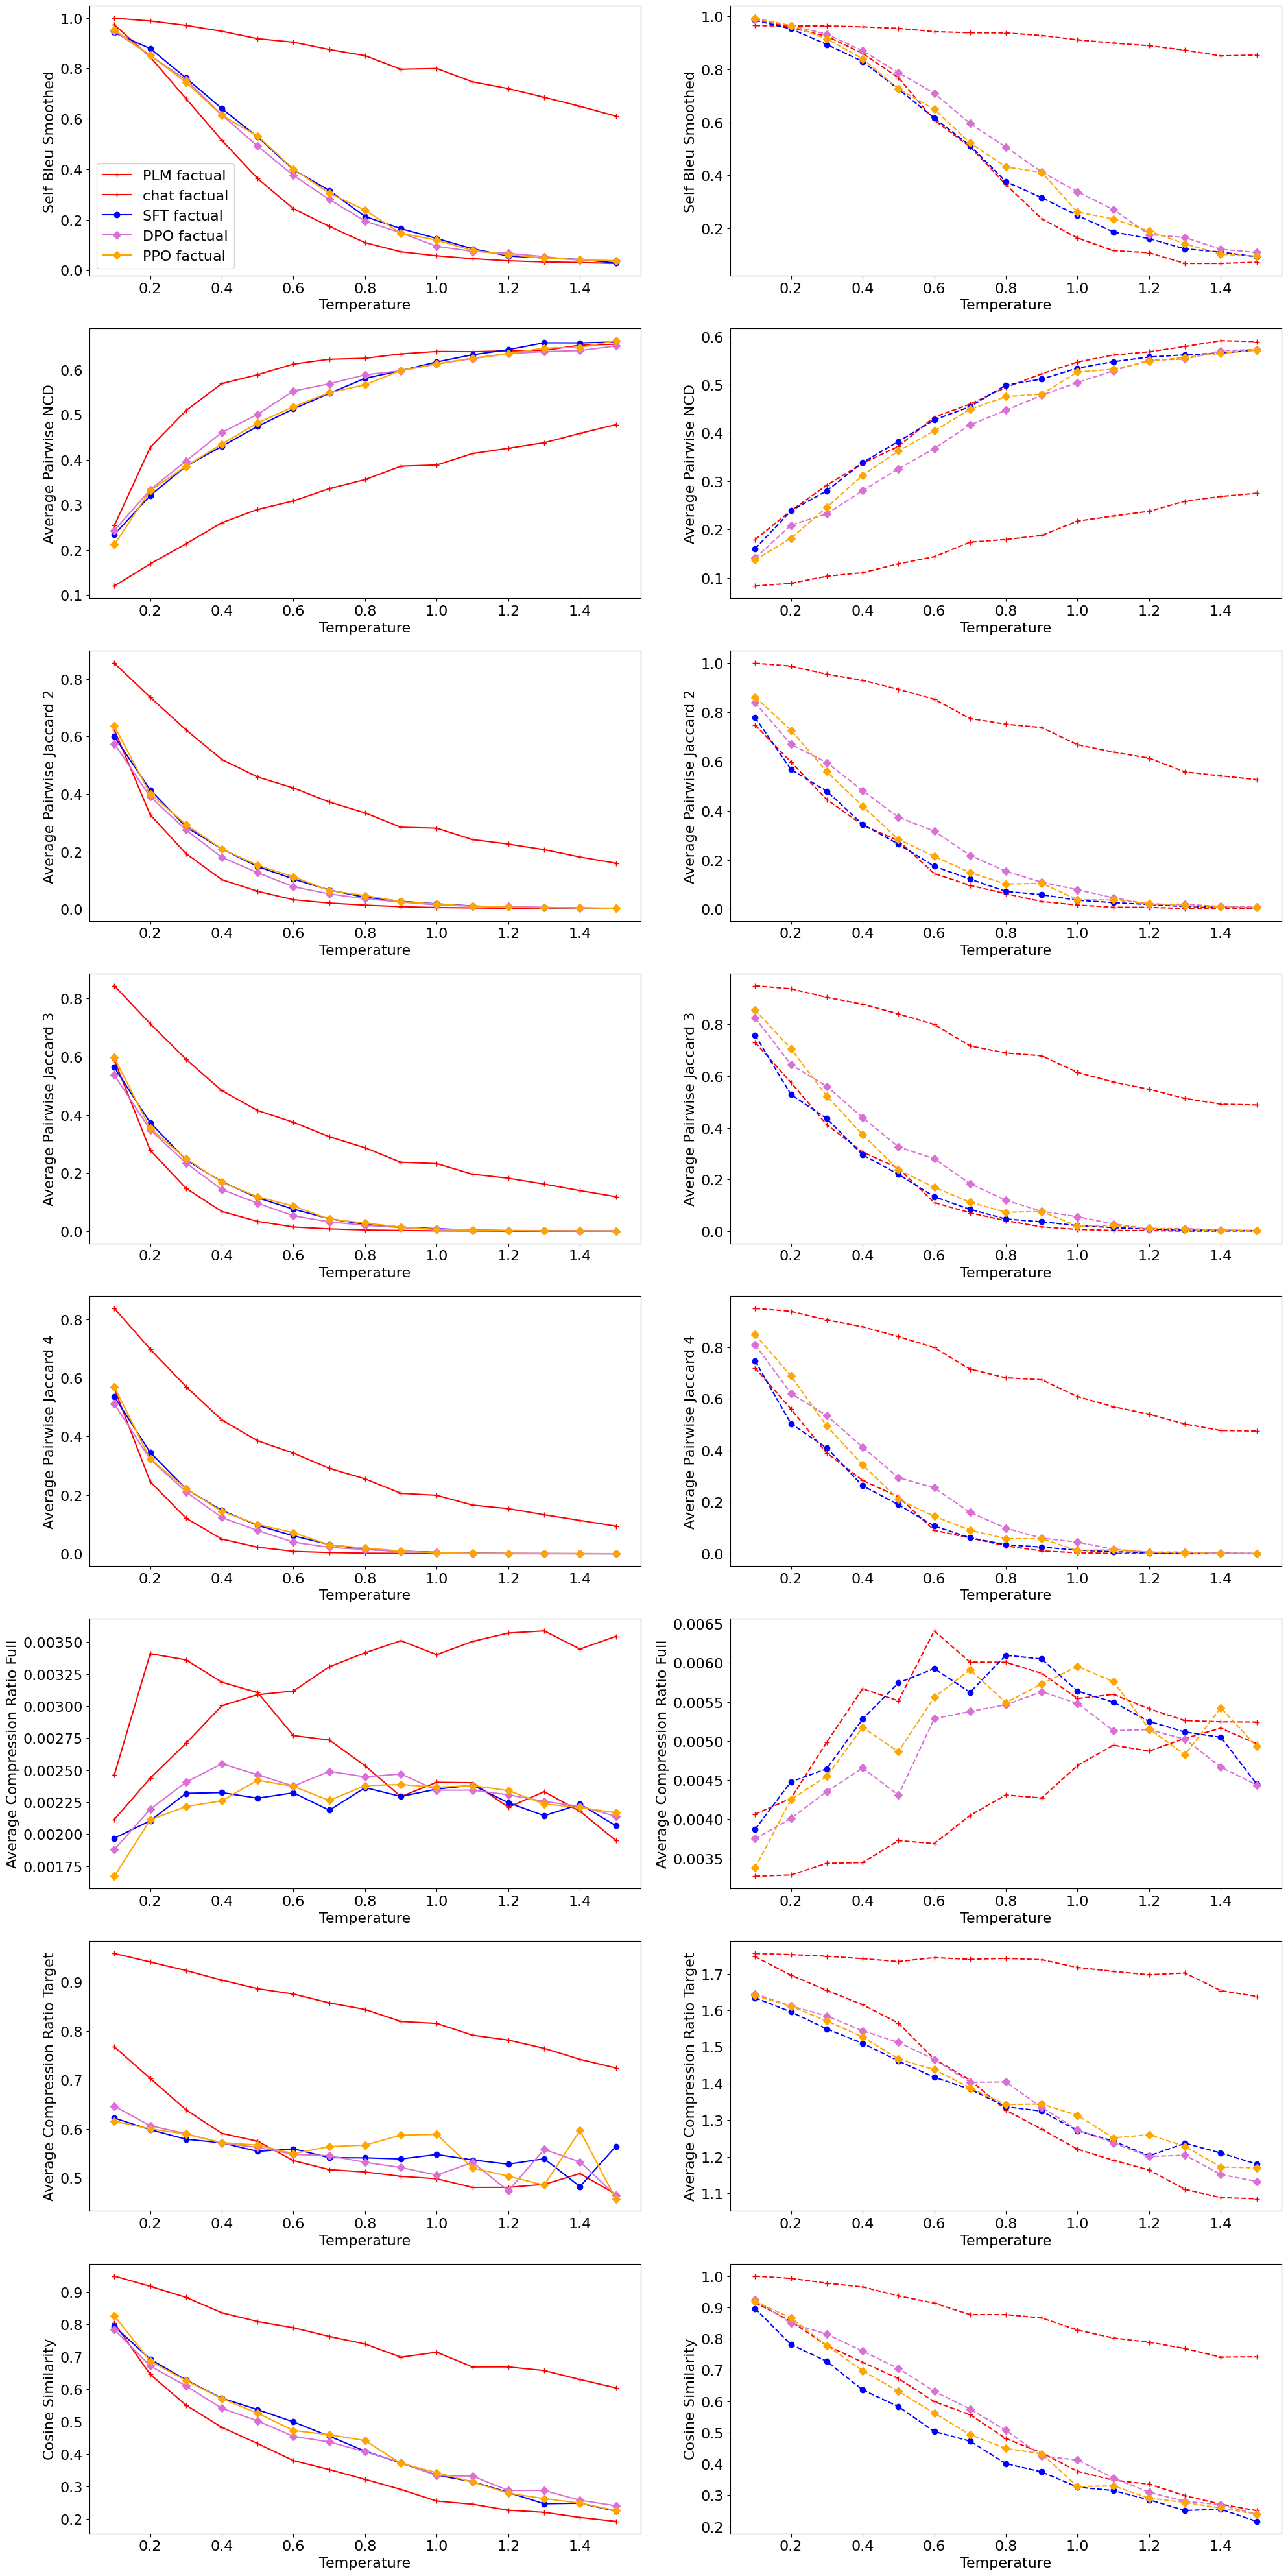

In [11]:
creative_factual_full_f = f"{os.path.dirname(os.getcwd())}/results/creative_factual_llama_finetune_full.png"

num_metrics = len(diversity_metrics.keys())
fig, axes = plt.subplots(num_metrics, 2, figsize=(20, 5*num_metrics))
# make font bigger
plt.rcParams.update({'font.size': 16})

text_effect = [path_effects.withStroke(linewidth=3, foreground='white')]

i=0
for index, metric in enumerate(diversity_metrics.keys()):

    for col_idx, result_sft in enumerate([llama2_sft_results_20_words, llama2_sft_results_5_words]):
        ax = axes[index, col_idx]

        scores_factual_sft = result_sft["factual"][metric]
        scores_creative_sft = result_sft["creative"][metric]

        result_plm = [llama2_results_20_words, llama2_results_5_words][col_idx] # col_idx
        scores_factual_plm = result_plm["factual"][metric]
        scores_creative_plm = result_plm["creative"][metric]

        result_chat = [llama2_chat_results_20_words, llama2_chat_results_5_words][col_idx]
        scores_factual_chat = result_chat["factual"][metric]
        scores_creative_chat = result_chat["creative"][metric]

        result_dpo = [llama2_dpo_results_20_words, llama2_dpo_results_5_words][col_idx]
        scores_factual_dpo = result_dpo["factual"][metric]
        scores_creative_dpo = result_dpo["creative"][metric]

        result_ppo = [llama2_ppo_results_20_words, llama2_ppo_results_5_words][col_idx]
        scores_factual_ppo = result_ppo["factual"][metric]
        scores_creative_ppo = result_ppo["creative"][metric]

        if col_idx == 0:
            # Plotting for factual scores
            ax.plot(temperatures, np.nanmean(scores_factual_plm[:, :, 0],axis=1), label='llama2 factual', marker='+', color="red")
            ax.plot(temperatures, np.nanmean(scores_factual_chat[:, :, 0],axis=1), label='llama2-chat factual', marker='+', color="red")
            ax.plot(temperatures, np.nanmean(scores_factual_sft[:, :, 0],axis=1), label='llama2-sft factual', marker='o', color="blue")
            ax.plot(temperatures, np.nanmean(scores_factual_dpo[:, :, 0],axis=1), label='llama2-dpo factual', marker='D', color="orchid")
            ax.plot(temperatures, np.nanmean(scores_factual_ppo[:, :, 0],axis=1), label='llama2-ppo factual', marker='D', color="orange")

        if col_idx == 1:
            # Plotting for creative scores
            ax.plot(temperatures, np.nanmean(scores_creative_plm[:, :, 0],axis=1), label='llama2 creative', marker='+', linestyle='--', color="red")
            ax.plot(temperatures, np.nanmean(scores_creative_chat[:, :, 0],axis=1), label='llama2-chat creative', marker='+', linestyle='--', color="red")
            ax.plot(temperatures, np.nanmean(scores_creative_sft[:, :, 0],axis=1), label='llama2-sft creative', marker='o', linestyle='--', color="blue")
            ax.plot(temperatures, np.nanmean(scores_creative_dpo[:, :, 0],axis=1), label='llama2-dpo creative', marker='D', linestyle='--', color="orchid")
            ax.plot(temperatures, np.nanmean(scores_creative_ppo[:, :, 0],axis=1), label='llama2-ppo creative', marker='D', linestyle='--', color="orange")

        ax.set_xlabel('Temperature')
        ax.set_ylabel(metric_label[i])
        # text_effect = [path_effects.withStroke(linewidth=3, foreground='white')]
        if i==0:
            ax.legend(['PLM factual', 'chat factual', 'SFT factual', 'DPO factual', 'PPO factual', 'PML creative', 'chat creative', 'SFT creative', 'DPO creative', 'PPO creative'])
        i+=1


plt.tight_layout()
plt.show()

fig.savefig(creative_factual_full_f, bbox_inches="tight") 
plt.close()


## Plot the difference in diversity between creative and factual changes for llama2 and llama2-chat

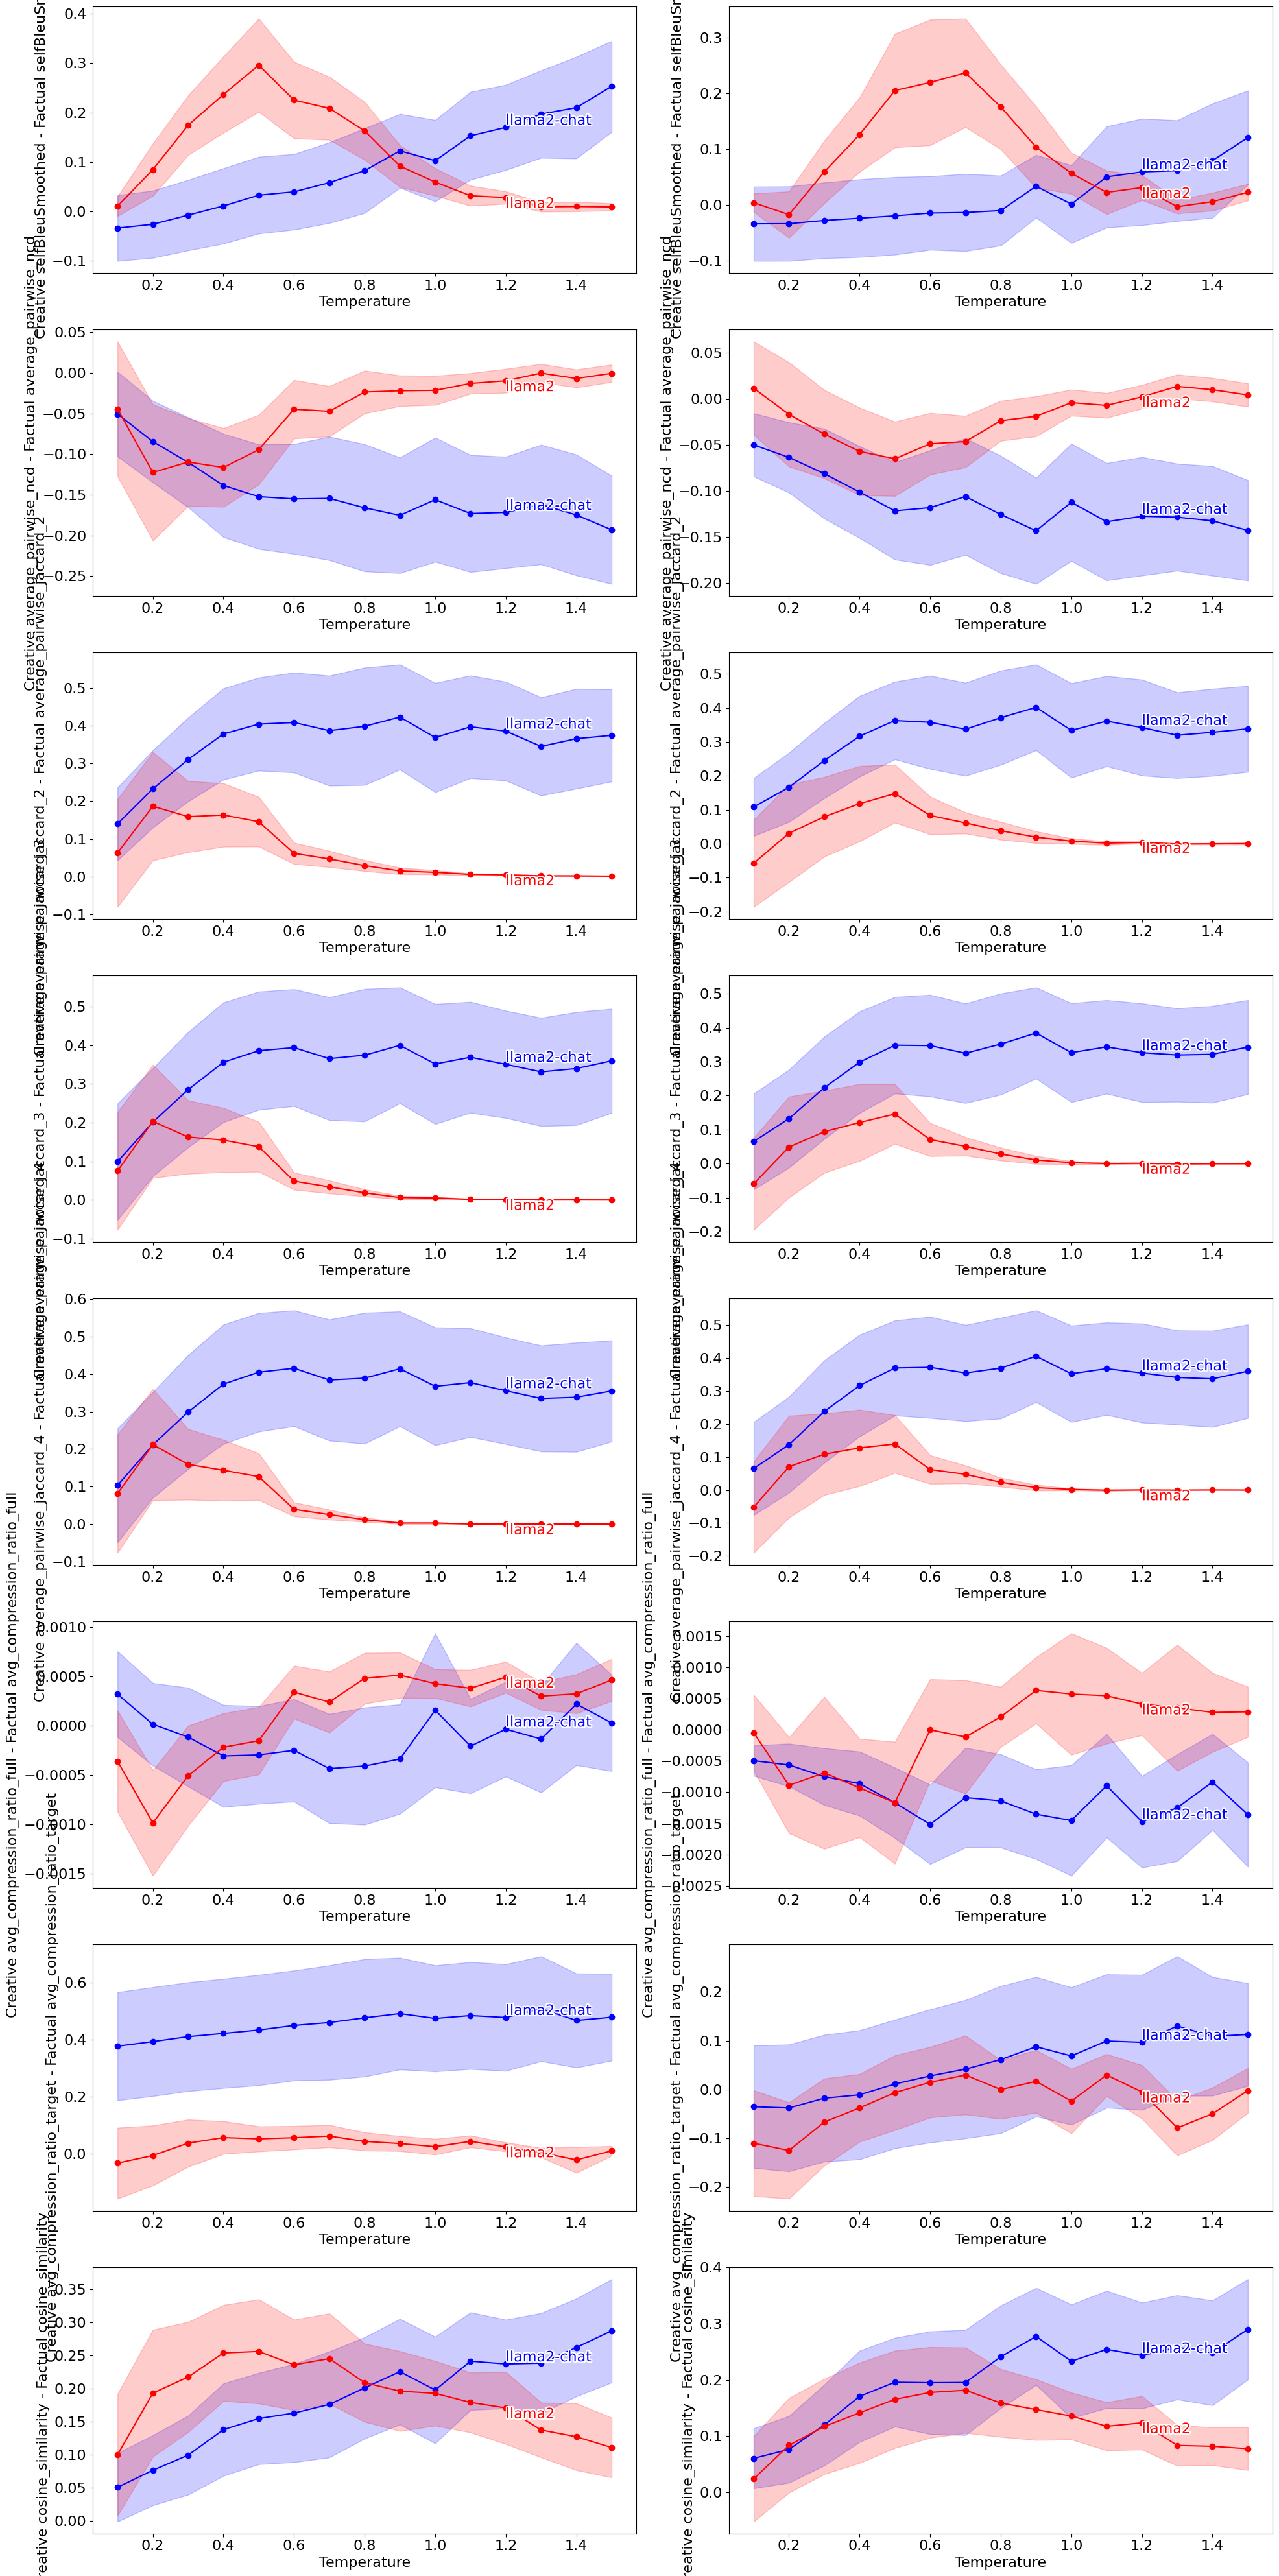

In [12]:
num_metrics = len(diversity_metrics.keys())
fig, axes = plt.subplots(num_metrics, 2, figsize=(20, 5*num_metrics))
# make font bigger
plt.rcParams.update({'font.size': 16})
text_effect = [path_effects.withStroke(linewidth=3, foreground='white')]

i=0
for index, metric in enumerate(diversity_metrics.keys()):

    for col_idx, result_chat in enumerate([llama2_chat_results_20_words, llama2_chat_results_5_words]):
        ax = axes[index, col_idx]

        scores_factual_chat = result_chat["factual"][metric]
        scores_creative_chat = result_chat["creative"][metric]

        result_plm = [llama2_results_20_words, llama2_results_5_words][col_idx]
        scores_factual_plm = result_plm["factual"][metric]
        scores_creative_plm = result_plm["creative"][metric]

        # Calculate differences
        diff_llamaa_chat = scores_creative_chat[:, :, 0] - scores_factual_chat[:, :, 0]
        diff_llamaa_plm = scores_creative_plm[:, :, 0] - scores_factual_plm[:, :, 0]

        # Plotting differences
        ax.plot(temperatures, diff_llamaa_chat.mean(axis=1), label='llama2-chat', marker='o', color="blue")
        ax.fill_between(temperatures, diff_llamaa_chat.mean(axis=1) - 2 * diff_llamaa_chat.std(axis=1) / np.sqrt(diff_llamaa_chat.shape[1]), 
                        diff_llamaa_chat.mean(axis=1) + 2 * diff_llamaa_chat.std(axis=1) / np.sqrt(diff_llamaa_chat.shape[1]), alpha=0.2, color="blue")

        ax.plot(temperatures, diff_llamaa_plm.mean(axis=1), label='llama2', marker='o', color="red")
        ax.fill_between(temperatures, diff_llamaa_plm.mean(axis=1) - 2 * diff_llamaa_plm.std(axis=1) / np.sqrt(diff_llamaa_plm.shape[1]), 
                        diff_llamaa_plm.mean(axis=1) + 2 * diff_llamaa_plm.std(axis=1) / np.sqrt(diff_llamaa_plm.shape[1]), alpha=0.2, color="red")

        end_temp = temperatures[-4]
        text_llama = ax.text(end_temp, diff_llamaa_chat.mean(axis=1)[-4], 'llama2-chat', color='blue', verticalalignment='bottom')
        text_llama.set_path_effects(text_effect)

        text_vicuna = ax.text(end_temp, diff_llamaa_plm.mean(axis=1)[-4], 'llama2', color='red', verticalalignment='top')
        text_vicuna.set_path_effects(text_effect)

        # ax.set_title(f"Metric: {metric} for Result {20 if col_idx == 0 else 5} max words")
        ax.set_xlabel("Temperature")
        ax.set_ylabel(f"Creative {metric} - Factual {metric}")
        i+=1

plt.tight_layout()
plt.show()